In [1]:
import os
import sys

import numpy as np
np.random.seed(7) # for reproducibility
import pandas as pd 
import pybedtools

import matplotlib.pyplot as plt
import seaborn as sns

import keras.backend as K
from keras.models import Model, load_model

import sys
sys.path.append("../Scripts/")
from IntegratedGradients import *
from util_funcs import *
from plotseqlogo import seqlogo_fig_cross

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
def precision(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	#TPs=K.sum(K.round(K.clip(y_true * y_pred , 0, 1)))
	predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
	precision = true_positives / (predicted_positives + K.epsilon())
	return precision

def recall(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	#TPs=K.sum(K.round(K.clip(y_ture * y_pred , 0, 1)))
	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + K.epsilon())
	return recall



RBPnames_low=np.array(['MBNL1', 'P53_NONO', 'PUM2', 'QKI', 'AGO3', 'FUS', 'TAF15', 'ZFP36', 'DICER1', 'EIF3A', 'EIF3D', 'EIF3G', 'SSB', 'PAPD5', 'CPSF4', 'CPSF3', 'RTCB', 'FXR1', 'NOP58', 'NOP56', 'FBL', 'LIN28A', 'LIN28B', 'UPF1', 'G35', 'G45', 'XPO5'])
RBPnames_med=np.array(['TARDBP', 'ELAVL2', 'ELAVL3', 'ELAVL4', 'RBM20', 'IGF2BP1', 'IGF2BP2', 'IGF2BP3', 'EWSR1', 'HNRNPD', 'RBPMS', 'SRRM4', 'AGO2', 'NUDT21', 'FIP1L1', 'CAPRIN1', 'FMR1iso7', 'FXR2', 'AGO1', 'L1RE1', 'ORF1'])
RBPnames_high=np.array(['DND1', 'CPSF7', 'CPSF6', 'CPSF1', 'CSTF2', 'CSTF2T', 'ZC3H7B', 'FMR1iso1', 'RBM10', 'MOV10', 'ELAVL1'])


path_to_model = "../Results/PARCLIP_models/"
path_to_modelhigh= path_to_model + "model_RBPshigh.h5"
path_to_modelmed= path_to_model + "model_RBPsmed.h5"
path_to_modellow= path_to_model + "model_RBPslow.h5"


model_high=load_model(path_to_modelhigh, custom_objects={'precision': precision,'recall': recall }) 
igres_high = integrated_gradients(model_high) 

model_med=load_model(path_to_modelmed, custom_objects={'precision': precision,'recall': recall }) 
igres_med = integrated_gradients(model_med) 

model_low=load_model(path_to_modellow, custom_objects={'precision': precision,'recall': recall }) 
igres_low = integrated_gradients(model_low) 


Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [4]:
##Function to prepare the input for the model from variants bedfile
##The bedfile should be as follows : chr	start	end	  variant_name    W/M     strand  where(start=end)

def encode_variant_bedline(bedline,genomefasta,flank_size=75):
    mut_a = bedline[4].split("/")[1]
    strand = bedline[5]
    if len(mut_a)==1:
        wild = pybedtools.BedTool(bedline[0] + "\t" + str(int(bedline[1])-flank_size) + "\t"  + str(int(bedline[2])+flank_size) + "\t" + 
                                  bedline[3] + "\t" + str(mut_a) + "\t" + bedline[5], from_string=True )
        if strand == "-" :
            mut_pos= flank_size
        else:
            mut_pos= flank_size-1
                            
        #wild = pybedtools.BedTool(bedline[0] + "\t" + bedline[1] + "\t" + bedline[2] + "\t" + bedline[3] + "\t"+ bedline[4] + "\t" + bedline[5], from_string=True)
        wild = wild.sequence(fi=genomefasta, tab=True, s=True)
        fastalist = open(wild.seqfn).read().split("\n")
        del fastalist[-1]
        seqs=[fasta.split("\t")[1] for fasta in fastalist]
        mut=seqs[0]
        mut = list(mut)
        mut[mut_pos] = mut_a
        mut = "".join(mut)
        seqs.append(mut)
        encoded_seqs =np.array([seq_to_1hot(seq) for seq in seqs])
        encoded_seqs = np.transpose(encoded_seqs,axes=(0,2,1))
        return(encoded_seqs)
                   
    


##Function to score variants using models with both sequence and region 
def score_variant_withregion(model,RBP_index,variant_bed,genomefasta,tr=0.1):
    reg_coded = np.full((250, 4), 0.25)
    region=np.array([reg_coded,reg_coded])
    score_list = []
    bed_list = []
    seqs_list = []
    for bedline in variant_bed:
        encoded_seqs = encode_variant_bedline(bedline,genomefasta)
        if encoded_seqs is not None:
            pred = model.predict([encoded_seqs,region])[:,RBP_index]
            score = (pred[1]-pred[0])
            if abs(score) > tr:
                score_list.append(score)
                bed_list.append(bedline)
                seqs_list.append(encoded_seqs)
    return(score_list,bed_list,seqs_list)


####Function to score variants using models with only sequence
def score_variant_onlyseq(model,RBP_index,variant_bed,genomefasta,tr=0.1):
    score_list = []
    bed_list = []
    seqs_list = []
    for bedline in variant_bed:
        encoded_seqs = encode_variant_bedline(bedline,genomefasta)
        if encoded_seqs is not None:
            pred = model.predict(encoded_seqs)[:,RBP_index]
            score = (pred[1]-pred[0])
            if abs(score) > tr:
                score_list.append(score)
                bed_list.append(bedline)
                seqs_list.append(encoded_seqs)
    return(score_list,bed_list,seqs_list) 


####Function to plot attribution map for variant using models with both sequence and region 
def plot_variant_map_withregion(bedlines,igres,RBP_index,genomefasta,figsave_path=""):
    for bedline in bedlines[0:bedlines.count()]:
        encoded_seqs = encode_variant_bedline(bedline,genomefasta)
        reg_coded = np.full((250, 4), 0.25)
        ex_seq = np.array([igres.explain([encoded_seqs[i],reg_coded],outc=RBP_index,reference=False)[0] for i in [0,1]])
        plt.close("all")
        seqlogo_fig_cross(np.transpose(ex_seq[:,50:100,:4],axes=(1,2,0)), vocab="RNA", figsize=(4,1.5), ncol=1, crosssite=True, cross_positions=[(24.5,25.5),(24.5,25.5),(24.5,25.5)])
        #plt.savefig(os.path.join(figsave_path,bedline[3]+"_"+str(RBP_index)+"_region.pdf"),dpi=300)
        #plt.savefig(os.path.join(figsave_path,bedline[3]+"_"+str(RBP_index)+"_region.png"),dpi=300)
        plt.show()
        
####Function to plot attribution map for variant using models with only sequence
def plot_variant_map_onlyseq(bedlines,igres,RBP_index,genomefasta,figsave_path=""):
    for bedline in bedlines[0:bedlines.count()]:
        encoded_seqs = encode_variant_bedline(bedline,genomefasta)
        ex_seq = np.array([igres.explain(encoded_seqs[i],outc=RBP_index,reference=False)[0] for i in [0,1]])
        plt.close("all")
        seqlogo_fig_cross(np.transpose(ex_seq[:,50:100,:4],axes=(1,2,0)), vocab="RNA", figsize=(4,1.5), ncol=1, crosssite=True, cross_positions=[(24.5,25.5),(24.5,25.5),(24.5,25.5)])
        #plt.savefig(os.path.join(figsave_path,bedline[3]+"_"+str(RBP_index)+"_region.pdf"),dpi=300)
        #plt.savefig(os.path.join(figsave_path,bedline[3]+"_"+str(RBP_index)+"_region.png"),dpi=300)
        plt.show()
        



In [5]:
variant_bed = """
... chr1    23463451    23463451    COSN20570016	C/T	+
... chr3	54360029	54360029	COSN6770341    C/G	+
... chr3	77695126	77695126	COSN28578284	G/C	+
... chr5	39393068	39393068	COSN5605138    T/A	+
... """

variant_bed = pybedtools.BedTool(variant_bed, from_string=True)
variant_bed.head()

chr1	23463451	23463451	COSN20570016	C/T	+
 chr3	54360029	54360029	COSN6770341	C/G	+
 chr3	77695126	77695126	COSN28578284	G/C	+
 chr5	39393068	39393068	COSN5605138	T/A	+
 

In [6]:
genomefasta="/data/ohler/iGenomes/Homo_sapiens/UCSC/hg19/Sequence/WholeGenomeFasta/genome.fa"

RBP_name="MBNL1"
model = model_low
RBPnames= RBPnames_low
igres = igres_low

RBP_index = np.where(RBPnames == RBP_name)[0][0]

MBNL1_score_list, MBNL1_bed_list, MBNL1_seqs_list = score_variant_withregion(model,RBP_index,variant_bed,genomefasta,tr=0.1)
print(MBNL1_score_list)

[-0.48881015, 0.26178157, -0.34999323, -0.17389178]


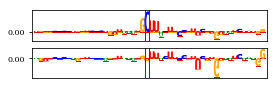

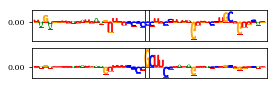

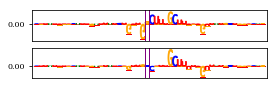

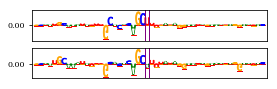

In [7]:
plot_variant_map_withregion(variant_bed,igres_low,0,genomefasta)